In [1]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16923 sha256=ace2619139046312652b3ea7f99dd298e5ac436544bd5750333f8585475bf3ec
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [ ]:
!unzip /content/data.zip

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [5]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

## Arsitektur & Model

### Pretrained model

In [7]:
from torchvision.models import mobilenet_v2

In [8]:
mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
    param.requires_grad = False

In [9]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [10]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [11]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [12]:
config = set_config({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

## Phase 1 : Adaptation
lr = standar | patience = kecil

In [13]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.2862 | Test_cost  = 0.3480 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1880 | Test_cost  = 0.2615 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a660c6320>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a660c6320>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1584 | Test_cost  = 0.1952 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1491 | Test_cost  = 0.3630 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1952


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1294 | Test_cost  = 0.3060 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1952
==> Execute Early Stopping at epoch: 5 | Best test_cost: 0.1952
==> Best model is saved at model


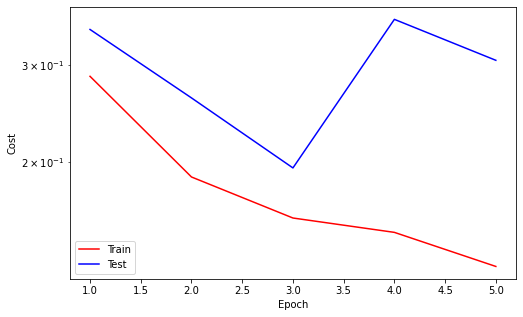

In [15]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2 : Fine Tuning
lr = dikecilin | patience ditambah

In [16]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1243 | Test_cost  = 0.1781 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1059 | Test_cost  = 0.1789 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1781


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0994 | Test_cost  = 0.1651 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0994 | Test_cost  = 0.1634 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0925 | Test_cost  = 0.1619 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0888 | Test_cost  = 0.1590 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0887 | Test_cost  = 0.1649 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1590


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0853 | Test_cost  = 0.1625 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1590


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0837 | Test_cost  = 0.1589 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0816 | Test_cost  = 0.1612 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1589


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0817 | Test_cost  = 0.1558 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0816 | Test_cost  = 0.1574 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1558


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0862 | Test_cost  = 0.1719 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1558


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0770 | Test_cost  = 0.1620 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1558


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0768 | Test_cost  = 0.1727 | 


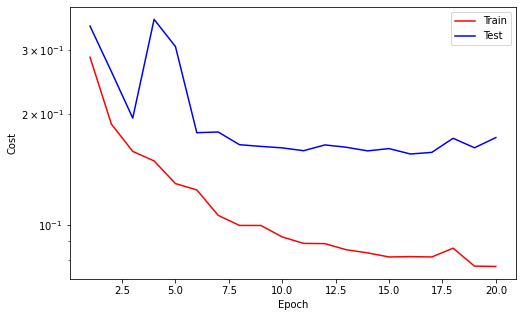

==> EarlyStop patience =  4 | Best test_cost: 0.1558


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0737 | Test_cost  = 0.1616 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1558
==> Execute Early Stopping at epoch: 21 | Best test_cost: 0.1558
==> Best model is saved at model


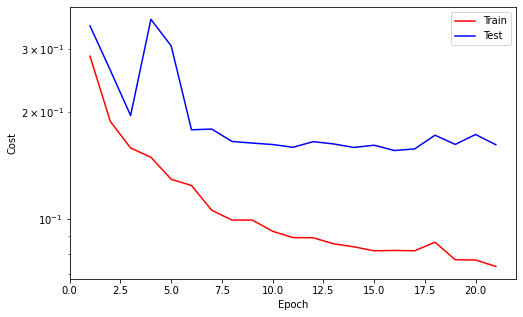

In [17]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Predict

In [18]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [19]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0

## Sanity Check

In [20]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

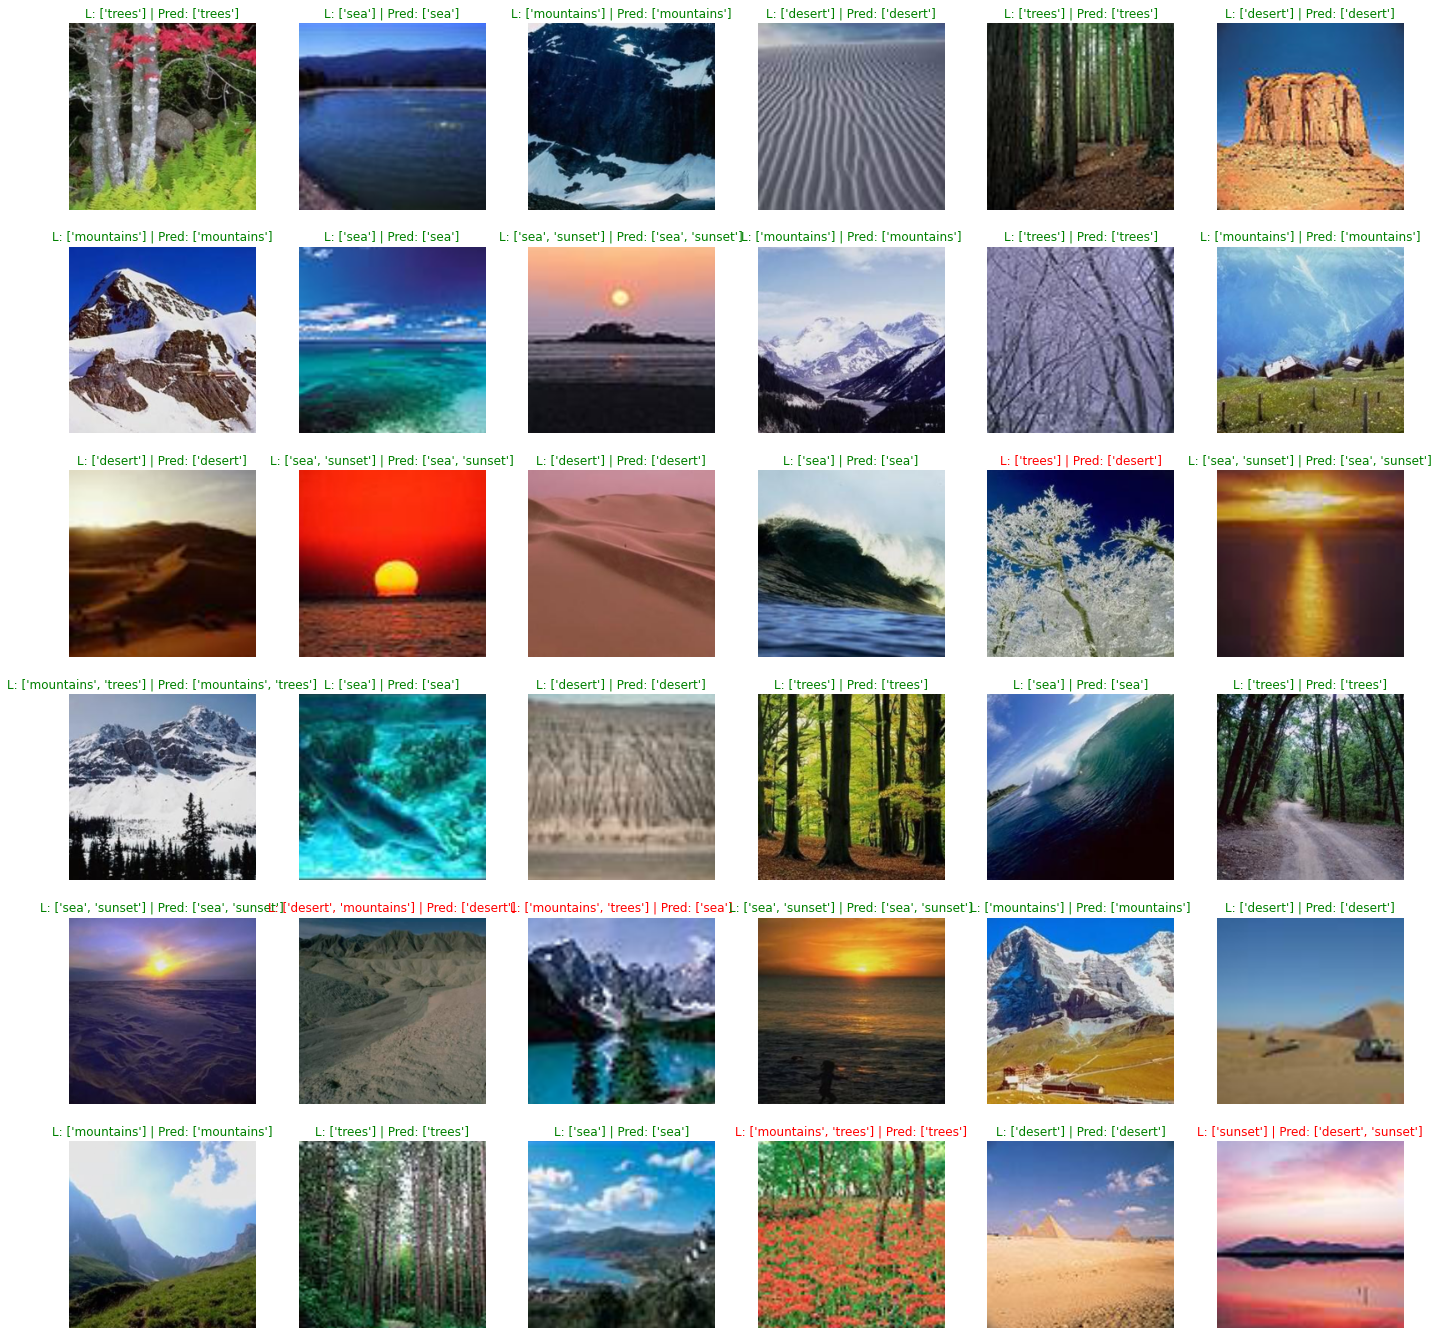

In [21]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color" : 'r'} if (label != pred).any() else {"color" : 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"L: {label} | Pred: {pred}", fontdict=font);
    ax.axis("off");


In [22]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 34%)
  adding: content/model/configs.pth (deflated 51%)
